In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
df = pd.read_csv("./datas/test_plan_featrues.csv")

In [3]:
print(df.shape)
df.head()

(14, 6)


,planId,tagList,locationList,durationDays,locationRatingAvg,likeCount
0,2,4 5 6 7,"1(1, 2, 3), 10(2, 3, 8), 3(3, 5), 4(2, 3, 6, 7...",3,4.512500,0
1,3,8 9 10 11,"12(1, 2, 3), 14(2, 3, 12, 13), 17(2, 3, 6, 7, ...",4,4.200000,4
2,4,7 12 13 14,"1(1, 2, 3), 58(1, 2, 3), 59(2, 3), 60(2, 3, 26...",30,4.485714,1
3,5,1 2 15 16 17 18,"27(1, 2, 3), 28(2, 3, 4), 29(16, 22), 30(23), ...",9,4.415000,0
4,6,19 20 21 22 23,"100(16, 35), 71(1, 2, 3), 72(2, 3, 4), 73(2, 3...",7,4.438461,10


In [4]:
# 🔹 tagList: Multi-label One-hot Encoding
df['tagList'] = df['tagList'].astype(str).apply(lambda x: list(map(int, x.strip().split())))
mlb_tag = MultiLabelBinarizer()
tag_encoded = mlb_tag.fit_transform(df['tagList'])

In [5]:
# 🔹 locationList: locationId 추출 → One-hot Encoding
def extract_location_ids(text):
    location_ids = []
    if pd.notna(text):
        pairs = text.split(', ')
        for pair in pairs:
            try:
                loc_id = int(pair.split('(')[0])
                location_ids.append(loc_id)
            except:
                continue
    return location_ids

# 🔹 locationList: typeId 추출 → One-hot Encoding
def extract_type_ids(text):
    type_ids = []
    if pd.notna(text):
        pairs = text.split(', ')
        for pair in pairs:
            try:
                type_text = pair.split('(')[1].replace(')', '')
                type_ids.extend(map(int, type_text.split(', ')))
            except:
                continue
    return list(set(type_ids))  # 중복 제거


In [6]:
df['locationIds'] = df['locationList'].apply(extract_location_ids)
mlb_loc = MultiLabelBinarizer()
location_encoded = mlb_loc.fit_transform(df['locationIds'])

In [7]:
df['typeIds'] = df['locationList'].apply(extract_type_ids)
mlb_type = MultiLabelBinarizer()
type_encoded = mlb_type.fit_transform(df['typeIds'])

In [8]:
# 🔹 durationDays, locationRatingAvg → Min-Max 정규화
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(df[['durationDays', 'locationRatingAvg']])

In [9]:
# 🔹 벡터 최종 결합
final_vectors = np.concatenate([
    tag_encoded,
    location_encoded,
    type_encoded,
    numeric_features
], axis=1)

In [10]:
# 🔹 결과 DataFrame 생성 (planId 포함)
vector_df = pd.DataFrame(final_vectors)
vector_df.insert(0, 'planId', df['planId'])

In [11]:
# 🔹 확인
print(vector_df.head())

   planId    0    1    2    3    4    5    6    7    8  ...  106  107  108  \
0       2  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
1       3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  ...  0.0  0.0  1.0   
2       4  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
3       5  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
4       6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0   

   109  110  111  112  113       114       115  
0  1.0  1.0  0.0  0.0  0.0  0.000000  0.539353  
1  1.0  0.0  0.0  0.0  0.0  0.037037  0.000000  
2  1.0  1.0  1.0  0.0  0.0  1.000000  0.493123  
3  1.0  0.0  1.0  1.0  0.0  0.222222  0.371075  
4  1.0  1.0  1.0  0.0  1.0  0.148148  0.411568  

[5 rows x 117 columns]


In [12]:
# 🔸 PCA로 2차원 축소
pca = PCA(n_components=2)
vector_2d_pca = pca.fit_transform(final_vectors)

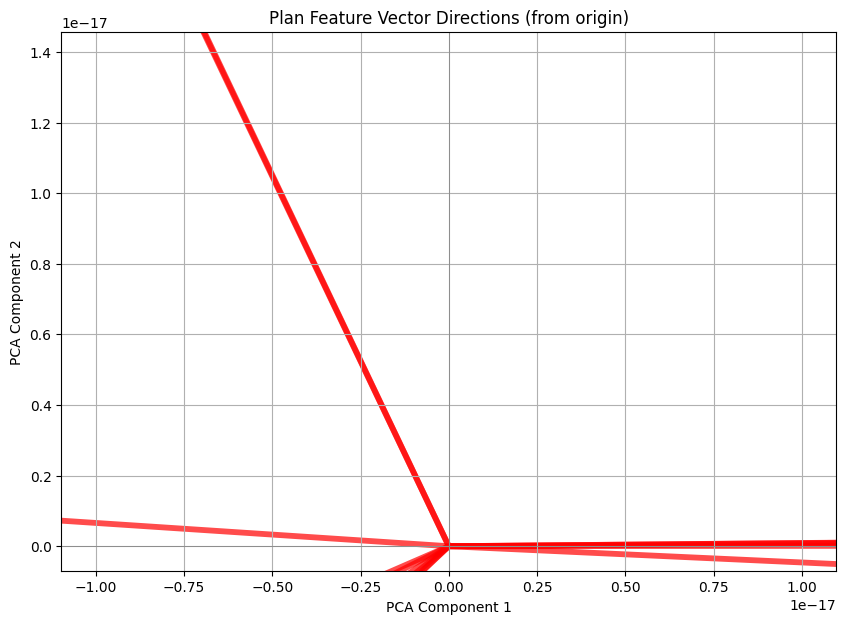

In [13]:
# 🔸 원점 기준 화살표 (quiver)
plt.figure(figsize=(10, 7))
plt.quiver(
    np.zeros(len(vector_2d_pca)),  # 원점 X
    np.zeros(len(vector_2d_pca)),  # 원점 Y
    vector_2d_pca[:, 0],           # 방향 X
    vector_2d_pca[:, 1],           # 방향 Y
    angles='xy', scale_units='xy', scale=1,
    color='red', alpha=0.7
)

# 🔸 planId 표시
for i, plan_id in enumerate(df['planId']):
    plt.text(vector_2d_pca[i, 0], vector_2d_pca[i, 1], str(plan_id), fontsize=9)

plt.title("Plan Feature Vector Directions (from origin)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid(True)
plt.axis('equal')
plt.show()

D:\Users\main\AppData\Local\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Users\main\AppData\Local\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "D:\Users\main\AppData\Local\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Users\main\AppData\Local\Python\Python313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_

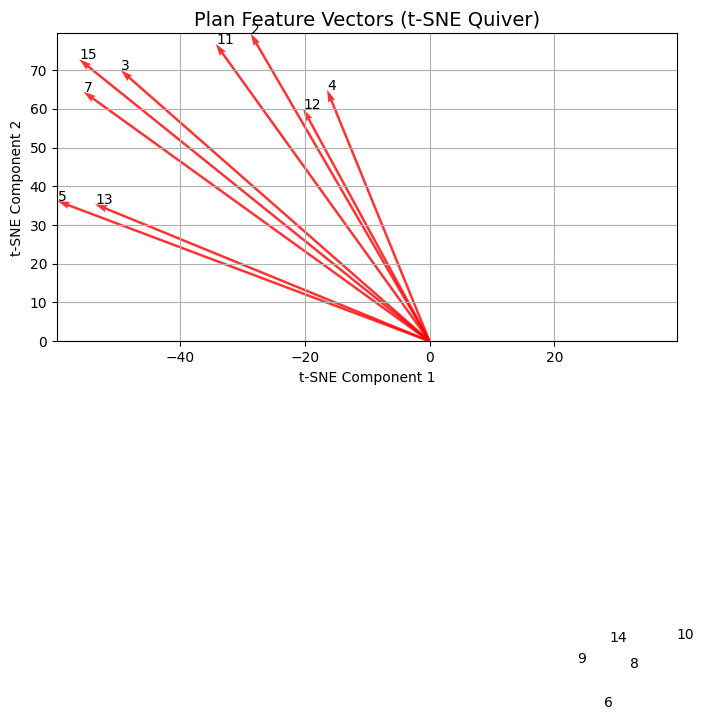

Plan 2: End point at (-28.66, 79.42)
Plan 3: End point at (-49.49, 69.97)
Plan 4: End point at (-16.42, 64.88)
Plan 5: End point at (-59.62, 36.17)
Plan 6: End point at (27.87, -94.50)
Plan 7: End point at (-55.43, 64.40)
Plan 8: End point at (32.00, -84.51)
Plan 9: End point at (23.59, -83.20)
Plan 10: End point at (39.54, -76.87)
Plan 11: End point at (-34.26, 76.77)
Plan 12: End point at (-20.24, 59.96)
Plan 13: End point at (-53.61, 35.38)
Plan 14: End point at (28.80, -77.64)
Plan 15: End point at (-56.14, 72.78)


In [14]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
vector_2d_tsne = tsne.fit_transform(final_vectors)

# 벡터 구성
u = vector_2d_tsne[:, 0]
v = vector_2d_tsne[:, 1]
start_x = np.zeros(len(u))
start_y = np.zeros(len(v))

# ✅ x, y 축 최대값 구해서 꼭짓점 안 잘리게
margin = 0.1  # 살짝 여유 공간
x_max = u.max() + margin
y_max = v.max() + margin
x_min = min(0, u.min() - margin)  # 만약 음수 방향도 있으면 보여주기

# 시각화
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# 화살표 그리기
ax.quiver(
    start_x, start_y, u, v,
    angles='xy', scale_units='xy', scale=1,
    color='red', alpha=0.8, width=0.004
)

# planId 표시 (원하는 경우 주석 해제)
for i, plan_id in enumerate(df['planId']):
    ax.text(u[i] + 0.05, v[i] + 0.05, str(plan_id), fontsize=10)

# ✅ 꼭짓점까지 축 범위 설정
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, y_max)

ax.set_title('Plan Feature Vectors (t-SNE Quiver)', fontsize=14)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.grid(True)
plt.tight_layout()
plt.show()

# 벡터 꼭짓점 좌표 출력
for i in range(len(u)):
    print(f'Plan {df['planId'][i]}: End point at ({u[i]:.2f}, {v[i]:.2f})')


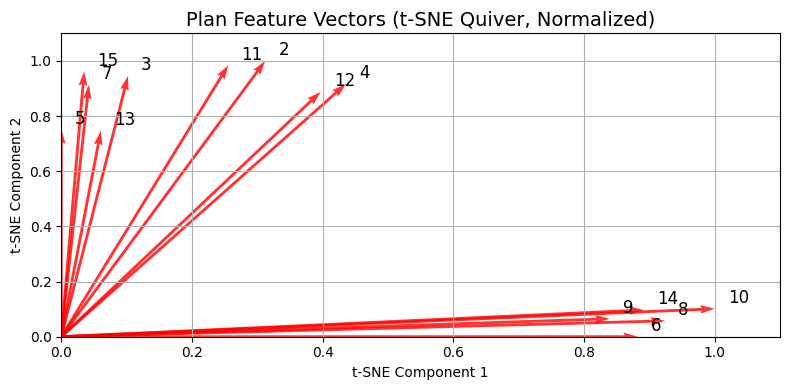

Plan 2: End point at (0.31, 1.00)
Plan 3: End point at (0.10, 0.95)
Plan 4: End point at (0.44, 0.92)
Plan 5: End point at (0.00, 0.75)
Plan 6: End point at (0.88, 0.00)
Plan 7: End point at (0.04, 0.91)
Plan 8: End point at (0.92, 0.06)
Plan 9: End point at (0.84, 0.07)
Plan 10: End point at (1.00, 0.10)
Plan 11: End point at (0.26, 0.98)
Plan 12: End point at (0.40, 0.89)
Plan 13: End point at (0.06, 0.75)
Plan 14: End point at (0.89, 0.10)
Plan 15: End point at (0.04, 0.96)


In [15]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
vector_2d_tsne = tsne.fit_transform(final_vectors)

# 🎯 정규화 (0~1 범위로)
scaler = MinMaxScaler()
vector_2d_norm = scaler.fit_transform(vector_2d_tsne)

# 벡터 구성
u = vector_2d_norm[:, 0]
v = vector_2d_norm[:, 1]
start_x = np.zeros(len(u))
start_y = np.zeros(len(v))

# 시각화
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# 화살표 그리기
ax.quiver(
    start_x, start_y, u, v,
    angles='xy', scale_units='xy', scale=1,
    color='red', alpha=0.8, width=0.004
)

# planId 표시
for i, plan_id in enumerate(df['planId']):
    ax.text(u[i] + 0.02, v[i] + 0.02, str(plan_id), fontsize=12)

# 축 범위
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)

ax.set_title('Plan Feature Vectors (t-SNE Quiver, Normalized)', fontsize=14)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.grid(True)

plt.tight_layout()
plt.show()

# 벡터 꼭짓점 확인
for i in range(len(u)):
    print(f'Plan {df['planId'][i]}: End point at ({u[i]:.2f}, {v[i]:.2f})')

In [16]:
user_df = pd.read_csv("./datas/test_user_plan_features.csv")

In [17]:
user_df.head()

,planId,tagList,locationList,durationDays,locationRatingAvg,likeCount
0,16,4 6 7,"1(1, 2, 3), 3(3, 5), 5(2, 3, 4), 7(3, 5), 9(2,...",3,4.475,2
1,17,8 10 11,"12(1, 2, 3), 17(2, 3, 6, 7, 17), 20(2, 3, 6, 7...",4,4.315,3
2,18,19 21 23,"71(1, 2, 3), 73(2, 3, 18), 75(2, 3, 18, 19), 7...",5,4.610,1


In [19]:
# 🔸 사용자 plan 데이터 벡터
user_vectors = vectorize_plan_df(user_df)

# 🔸 전체 벡터 병합 후 t-SNE 적용
all_vectors = np.vstack([final_vectors, user_vectors])
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
tsne_result = tsne.fit_transform(all_vectors)

# 🔸 정규화 (0~1 범위)
scaler = MinMaxScaler()
tsne_norm = scaler.fit_transform(tsne_result)

# 🔸 기존 플랜 / 사용자 플랜 나누기
u = tsne_norm[:len(df), 0]
v = tsne_norm[:len(df), 1]
user_u = tsne_norm[len(df):, 0]
user_v = tsne_norm[len(df):, 1]

# 🔸 시작점
start_x = np.zeros(len(u))
start_y = np.zeros(len(v))
user_start_x = np.zeros(len(user_u))
user_start_y = np.zeros(len(user_v))

# 🔸 시각화
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# 🔴 기존 플랜 (빨간 화살표)
ax.quiver(start_x, start_y, u, v, angles='xy', scale_units='xy', scale=1,
          color='red', alpha=0.8, width=0.004)

# 🔵 사용자 플랜 (파란 화살표)
ax.quiver(user_start_x, user_start_y, user_u, user_v, angles='xy', scale_units='xy', scale=1,
          color='blue', alpha=0.9, width=0.004)

# 텍스트 라벨
for i, plan_id in enumerate(df['planId']):
    ax.text(u[i] + 0.01, v[i] + 0.01, str(plan_id), fontsize=10, color='darkred')

for i, plan_id in enumerate(user_df['planId']):
    ax.text(user_u[i] + 0.01, user_v[i] + 0.01, str(plan_id), fontsize=10, color='navy')

# 축 설정
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_title('Plan Feature Vectors with User Plans (t-SNE + Normalized)', fontsize=14)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.grid(True)
plt.tight_layout()
plt.show()

# 벡터 꼭짓점 출력
for i in range(len(df)):
    print(f'Plan {df["planId"][i]}: End point at ({u[i]:.2f}, {v[i]:.2f})')

for i in range(len(user_df)):
    print(f'User Plan {user_df["planId"][i]}: End point at ({user_u[i]:.2f}, {user_v[i]:.2f})')

NameError: name 'vectorize_plan_df' is not defined

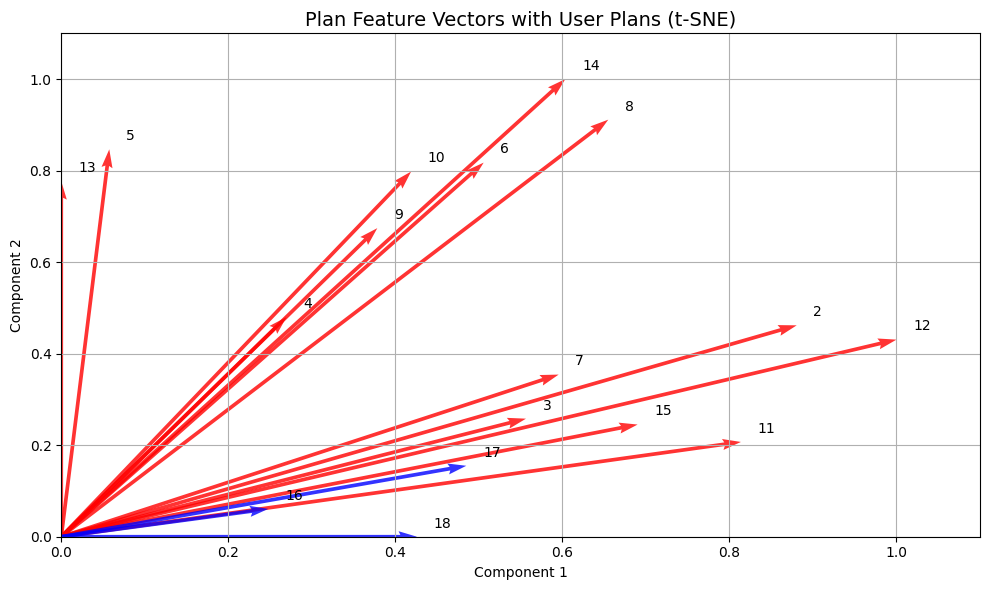

In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ✅ 데이터 불러오기
df = pd.read_csv('./datas/test_plan_featrues.csv')
user_df = pd.read_csv('./datas/test_user_plan_features.csv')

# 🔸 TF-IDF: tagList
tfidf_tag = TfidfVectorizer()
tfidf_tag.fit(pd.concat([df['tagList'], user_df['tagList']]).astype(str))
tag_vec_df = tfidf_tag.transform(df['tagList'].astype(str)).toarray()
tag_vec_user = tfidf_tag.transform(user_df['tagList'].astype(str)).toarray()

# 🔸 MultiLabel: locationId (괄호 앞 숫자 추출)
def extract_location_ids(col):
    return col.apply(lambda x: [item.split('(')[0] for item in str(x).split(', ')])

df_loc = extract_location_ids(df['locationList'])
user_loc = extract_location_ids(user_df['locationList'])

mlb_loc = MultiLabelBinarizer()
mlb_loc.fit(pd.concat([df_loc, user_loc]))
loc_vec_df = mlb_loc.transform(df_loc)
loc_vec_user = mlb_loc.transform(user_loc)

# 🔸 Numeric
num_vec_df = df[['durationDays', 'locationRatingAvg']].fillna(0).values
num_vec_user = user_df[['durationDays', 'locationRatingAvg']].fillna(0).values

# ✅ 최종 벡터
final_vectors = np.hstack([tag_vec_df, loc_vec_df, num_vec_df])
user_vectors = np.hstack([tag_vec_user, loc_vec_user, num_vec_user])

# ✅ 병합
all_vectors = np.vstack([final_vectors, user_vectors])

# ✅ t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
vector_2d_tsne = tsne.fit_transform(all_vectors)

# ✅ 정규화 (0~1)
scaler = MinMaxScaler()
vector_2d_norm = scaler.fit_transform(vector_2d_tsne)

# 📌 시각화
u = vector_2d_norm[:, 0]
v = vector_2d_norm[:, 1]
start_x = np.zeros_like(u)
start_y = np.zeros_like(v)

fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# 기존 plan: 빨간색
ax.quiver(start_x[:len(df)], start_y[:len(df)], u[:len(df)], v[:len(df)],
          angles='xy', scale_units='xy', scale=1, color='red', alpha=0.8, width=0.004)

# 사용자 plan: 파란색
ax.quiver(start_x[len(df):], start_y[len(df):], u[len(df):], v[len(df):],
          angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.8, width=0.004)

# planId 표시
all_plan_ids = list(df['planId']) + list(user_df['planId'])
for i, plan_id in enumerate(all_plan_ids):
    ax.text(u[i] + 0.02, v[i] + 0.02, str(plan_id), fontsize=10)

ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_title('Plan Feature Vectors with User Plans (t-SNE)', fontsize=14)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.grid(True)
plt.tight_layout()
plt.show()
